In [1]:
import numpy as np
import pypianoroll
import pandas as pd
import Functions as f
import os
import matplotlib.pyplot as plt

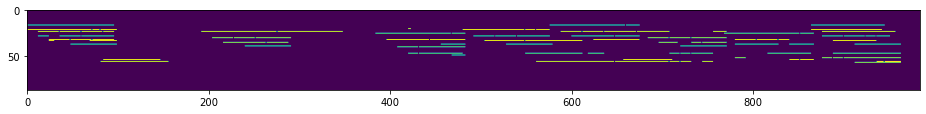

In [25]:
multitrack = pypianoroll.read("PopTransformer-run-2-001-BEST_Best.midi")
multitrack.binarize()
combined_track = multitrack.blend()
combined_track = combined_track[:,21:109]
plt.figure(figsize=(16, 10))
plt.imshow(combined_track.T)

In [7]:
combined_track.shape

(4824, 128)

# Step1: read the MIDI file and extract the combined pianoroll

In [2]:
# this function returns the entire pianoroll of the midi file
def getPianoroll(path):
    # read the midi file, convert to multitrack object with pypianoroll
    
    try: 
        multitrack = pypianoroll.read(path)
        multitrack.binarize()
        combined_track = multitrack.blend()
        combined_track = combined_track[:,21:109]
        combined_track[combined_track>1] = 1
    except:
        print("error: ", path)
        return 1
    
    return 1
    
    # binarize the tracks
    multitrack.binarize()
    
    # there are two tracks, one for right hand, and one for left, combine them since 
    #  it is one hot encoding, blend function returns the numpy array
    #  shape: (music_length, 128)
    combined_track = multitrack.blend()
    
    # reduce the pich range for pianos sectrion only 88
    #  original: C(-2) / index 0 -- G(9) / index (127)
    #  piano: A(0) / index 21  --  C(8) / index (108)
    combined_track = combined_track[:,21:109]
    
    # make sure that the entries are 0 or 1
    combined_track[combined_track>1] = 1
    #print(len(combined_track[:,0]))
    
    return combined_track
    

In [12]:
multitrack = pypianoroll.read("testout/black_key_original.mid")
multitrack.tracks[1][0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0, 75,  0,  0,  0, 75,  0,  0, 75,  0,  0,  0,  0, 89,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0], dtype=uint8)

In [5]:
track = getPianoroll("testout/black_key_original.mid")

In [8]:
track[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [12]:
track
f.midiwrite("testout/organ_check.mid",track,dtm=0.08)

# Step2: segment the pianoroll to subrolls with length 3000 gap 300

In [3]:
def segmentRoll(file_name,roll,output_folder,sample_len):
    # compute number of segments: = music length - segment length + 1
    nsample = len(roll) - sample_len
    #print(len(roll))
    #print(sample_len)
    i=0
    
    # make segments, shape (sample_len,88), store in the folder in csv files
    while i < nsample:
        name = file_name[:-4] + "- " + str(i) +".csv"
        output_path_train = os.path.join(output_folder,"Train",name)
        output_path_val = os.path.join(output_folder,"Val",name)
        output_path_test = os.path.join(output_folder,"Test",name)
        segment_roll = roll[i : i+sample_len , :]
       
        # I want to put 14% into validation set and 9% into test set
        #  roll a number from uniform distribution [0,1], if it's less than 0.14, val set
        #  if it's bigger than 0.91, test set
        num = np.random.uniform(0,1)
        if num < 0.14:
            #print(output_path_val)
            np.savetxt(output_path_val,segment_roll,delimiter=",",fmt="%d")
        #elif num > 0.91:
            #print(output_path_test)
            #np.savetxt(output_path_test,segment_roll,delimiter=",",fmt="%d")
        else:
            #print(output_path_train)
            np.savetxt(output_path_train,segment_roll,delimiter=",",fmt="%d")
        
        
        #np.savetxt(output_path,segment_roll,delimiter=",",fmt="%d")
        
        i += 300
        
        if i >= nsample:
            j = len(roll) - sample_len - 1
            name = file_name[:-4] + "- " + str(j) +".csv"
            output_path_train = os.path.join(output_folder,"Train",name)
            segment_roll = roll[-(sample_len):]
            np.savetxt(output_path_train,segment_roll,delimiter=",",fmt="%d")
            break
            
    

In [4]:
num = np.random.uniform(0,1,30)
num

array([0.63261182, 0.43963623, 0.15803412, 0.54187777, 0.77276358,
       0.58012533, 0.88185482, 0.86974643, 0.971556  , 0.56454322,
       0.75853326, 0.5449731 , 0.4208847 , 0.40133909, 0.22787573,
       0.02254719, 0.82628089, 0.02660039, 0.90879473, 0.9611032 ,
       0.73287498, 0.0101888 , 0.86540896, 0.74200841, 0.67509445,
       0.32202905, 0.30540215, 0.56253531, 0.83548585, 0.99923158])

# Step3: combine the functions

In [3]:
def generateData(file_name,file_path,output_folder,sample_len=600):
    # get whole piano roll
    roll = getPianoroll(file_path)
    
    # generate segments
    #segmentRoll(file_name,roll,output_folder,sample_len)

In [4]:
folder = "Piano_Collections"
subfolder = os.listdir(folder)
subfolder

ful_path = []
for i in np.arange(len(subfolder)):
    full_folder = os.path.join(folder,subfolder[i])
    names = os.listdir(full_folder)
    path = map(lambda x: os.path.join(full_folder,x), names)
    path = list(path)
    ful_path.extend(path)
ful_path[-10:]
print(len(ful_path))

1669


In [5]:
from tqdm.auto import tqdm
progress = tqdm(range(len(ful_path)))
for i in ful_path:
    generateData("a",i,"k",10)
    progress.update(1)

  0%|          | 0/1669 [00:00<?, ?it/s]

W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pretty_midi\pretty_midi.py:97: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(
W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pypianoroll\inputs.py:225: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60.0 / np.diff(beat_times_one_more)


error:  Piano_Collections\Others\jsrjeuxd.mid
error:  Piano_Collections\Others\jsrmiro1.mid
error:  Piano_Collections\Others\jsrmiro4.mid
error:  Piano_Collections\Others\jsrmiro5.mid


# test run - runs perfectly

In [40]:
file_name = "chpn_op10_e05.mid"
file_path = "testout/black_key_original.mid"
output_folder = "Handcrafted Dataset - One Hot"
generateData(file_name,file_path,output_folder,600)

In [6]:
# define the function to read the csv file, write to midi, and see if they are good
def csv_to_midi(path,dtm=0.1,num=0):
    roll = pd.read_csv(path,header=None)
    roll = np.array(roll)
    f.midiwrite("testout/csv-check"+str(num)+".mid",roll,dtm=dtm)

In [61]:
num = 3400
path = "Handcrafted Dataset - One Hot/Train/mazrka40- "+str(num)+".csv"
csv_to_midi(path,dtm=0.024,num=num)

In [ ]:
roll = pd.read_csv(path,header=None)
roll = np.array(roll)
roll.shape

# serious business - generate data sets

# Liszt

In [4]:
# get filenames
fnames = os.listdir("Piano_Collections/Liszt")
fnames[:10]

['01pasali.mid',
 '01promes.mid',
 '02holnit.mid',
 '02regven.mid',
 '03linvit.mid',
 '03manger.mid',
 '04adeste.mid',
 '04gita.mid',
 '05littre.mid',
 '05rimpro.mid']

In [5]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Liszt"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[124:126] # 2 126 127 146

['Piano_Collections\\Liszt\\festetic.mid',
 'Piano_Collections\\Liszt\\feux.mid']

In [6]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Liszt"

In [9]:
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([125,215])
for i in np.arange(0,len(fnames)):
    #if i in a:
        #progress_bar.update(1)
        #continue     
    generateData(fnames[i],fnames_ful[i],output_folder,1000)
    progress_bar.update(1)

  0%|          | 0/319 [00:00<?, ?it/s]

error:  Piano_Collections\Liszt\feux.mid
error:  Piano_Collections\Liszt\mazeppa.mid


## Chopin

In [4]:
# get filenames
fnames = os.listdir("Piano_Collections/Chopin")
fnames[:10]

['algrcrt3.mid',
 'at09op10.mid',
 'ballade3.mid',
 'berceuse.mid',
 'blschbub.mid',
 'buena.mid',
 'ch-etn04.mid',
 'ch-etn10.mid',
 'ch-etude.mid',
 'chlargo.mid']

In [5]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Chopin"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[124:126] # 2 126 127 146

['Piano_Collections\\Chopin\\lecpsb3.mid',
 'Piano_Collections\\Chopin\\lecpsd3.mid']

In [6]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Chopin"

In [9]:
from tqdm.auto import tqdm
b = 182
progress_bar = tqdm(np.arange(70,b))
a = np.array([2,123, 125,126, 127,141, 144,145])
for i in np.arange(70,b):
    #if i in a:
        #continue
        #progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,1000)
    print(i)
    print(fnames[i])
    progress_bar.update(1)

  0%|          | 0/112 [00:00<?, ?it/s]

70
chpn-p19.mid
71
chpn-p2.mid
72
chpn-p20.mid
73
chpn-p21.mid
74
chpn-p22.mid
75
chpn-p23.mid
76
chpn-p24.mid
77
chpn-p3.mid
78
chpn-p4.mid
79
chpn-p5.mid
80
chpn-p6.mid
81
chpn-p7.mid
82
chpn-p8.mid
83
chpn-p9.mid
84
chpnimpu.mid
85
chpn_op10_e01.mid
86
chpn_op10_e05.mid
87
chpn_op10_e12.mid
88
chpn_op23.mid
89
chpn_op25_e1.mid
90
chpn_op25_e11.mid
91
chpn_op25_e12.mid
92
chpn_op25_e2.mid
93
chpn_op25_e3.mid
94
chpn_op25_e4.mid
95
chpn_op27_1.mid
96
chpn_op27_2.mid
97
chpn_op33_2.mid
98
chpn_op33_4.mid
99
chpn_op35_1.mid
100
chpn_op35_2.mid
101
chpn_op35_3.mid
102
chpn_op35_4.mid
103
chpn_op53.mid
104
chpn_op66.mid
105
chpn_op7_1.mid
106
chpn_op7_2.mid
107
chp_op18.mid
108
chp_op31.mid
109
chsc3.mid
110
ch_10-11.mid
111
ch_10-2.mid
112
ch_10-6.mid
113
ch_10-7.mid
114
ch_10-8.mid
115
cmazurka.mid
116
contreda.mid
117
etn07o25.mid
118
etn10o25.mid
119
etude3.mid
120
fantop49.mid
121
fugaam.mid
122
lecpe8b.mid
123
lecpsa3.mid
124
lecpsb3.mid
125
lecpsd3.mid
126
mazrka01.mid
127
mazrka02

## Mozart

In [14]:
# get filenames
fnames = os.listdir("Piano_Collections/Mozart")
fnames[:10]

['k281-1.mid',
 'k281-2.mid',
 'kv025.mid',
 'kv1a.mid',
 'kv1b.mid',
 'kv1c.mid',
 'kv1d.mid',
 'kv1e.mid',
 'kv2.mid',
 'kv3.mid']

In [15]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Mozart"
folder2 = "mozart"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Mozart\\k281-1.mid',
 'Piano_Collections\\Mozart\\k281-2.mid',
 'Piano_Collections\\Mozart\\kv025.mid',
 'Piano_Collections\\Mozart\\kv1a.mid',
 'Piano_Collections\\Mozart\\kv1b.mid',
 'Piano_Collections\\Mozart\\kv1c.mid',
 'Piano_Collections\\Mozart\\kv1d.mid',
 'Piano_Collections\\Mozart\\kv1e.mid',
 'Piano_Collections\\Mozart\\kv2.mid',
 'Piano_Collections\\Mozart\\kv3.mid']

In [16]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Mozart"

In [17]:
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([20,21])
for i in np.arange(0,len(fnames)):
    #if i in a:
        #progress_bar.update(1)
        #continue
    generateData(fnames[i],fnames_ful[i],output_folder,2000)
    progress_bar.update(1)

  0%|          | 0/86 [00:00<?, ?it/s]

error:  Piano_Collections\Mozart\lempsb4.mid
error:  Piano_Collections\Mozart\lempsc4.mid


W:\Tools\Anaconda3\envs\pytorch\lib\site-packages\pypianoroll\inputs.py:225: RuntimeWarning: divide by zero encountered in true_divide
  bpm = 60.0 / np.diff(beat_times_one_more)


## Beethoven

In [18]:
fnames = os.listdir("Piano_Collections/Beethoven")
fnames[:10]

['afav.mid',
 'appass_1.mid',
 'appass_2.mid',
 'appass_3.mid',
 'baga01.mid',
 'baga02.mid',
 'baga03.mid',
 'baga04.mid',
 'baga05.mid',
 'baga06.mid']

In [19]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Beethoven"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Beethoven\\afav.mid',
 'Piano_Collections\\Beethoven\\appass_1.mid',
 'Piano_Collections\\Beethoven\\appass_2.mid',
 'Piano_Collections\\Beethoven\\appass_3.mid',
 'Piano_Collections\\Beethoven\\baga01.mid',
 'Piano_Collections\\Beethoven\\baga02.mid',
 'Piano_Collections\\Beethoven\\baga03.mid',
 'Piano_Collections\\Beethoven\\baga04.mid',
 'Piano_Collections\\Beethoven\\baga05.mid',
 'Piano_Collections\\Beethoven\\baga06.mid']

In [20]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Beethoven"

In [21]:
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([86,88,89,90,93])
for i in np.arange(0,len(fnames)):
    #if i in a:
       # continue
        #progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,1000)
    progress_bar.update(1)

  0%|          | 0/108 [00:00<?, ?it/s]

error:  Piano_Collections\Beethoven\bemfi2pb.mid
error:  Piano_Collections\Beethoven\bev2i3pb.mid
error:  Piano_Collections\Beethoven\bev3i7pb.mid
error:  Piano_Collections\Beethoven\bev6i6pb.mid


# Haydn

In [22]:
fnames = os.listdir("Piano_Collections/Haydn")
fnames[:10]

['12_germa.mid',
 '12_men.mid',
 '12_menu.mid',
 '12_menue.mid',
 'allegret.mid',
 'allegro_.mid',
 'capricci.mid',
 'dance_in.mid',
 'fantasia.mid',
 'gdance1.mid']

In [23]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Haydn"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Haydn\\12_germa.mid',
 'Piano_Collections\\Haydn\\12_men.mid',
 'Piano_Collections\\Haydn\\12_menu.mid',
 'Piano_Collections\\Haydn\\12_menue.mid',
 'Piano_Collections\\Haydn\\allegret.mid',
 'Piano_Collections\\Haydn\\allegro_.mid',
 'Piano_Collections\\Haydn\\capricci.mid',
 'Piano_Collections\\Haydn\\dance_in.mid',
 'Piano_Collections\\Haydn\\fantasia.mid',
 'Piano_Collections\\Haydn\\gdance1.mid']

In [24]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Haydn"

In [25]:
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(len(fnames)))
a = np.array([])
for i in np.arange(len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/160 [00:00<?, ?it/s]

# Clementi

In [49]:
fnames = os.listdir("Piano_Collections/Clementi")
fnames[:10]

['clem26_3.mid',
 'clem5031.mid',
 'clem5032.mid',
 'clem5033.mid',
 'clem5034.mid',
 'clemm.mid',
 'clemm2.mid',
 'clemm3.mid',
 'clmu07_3.mid',
 'clmu12_2.mid']

In [50]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Clementi"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Clementi\\clem26_3.mid',
 'Piano_Collections\\Clementi\\clem5031.mid',
 'Piano_Collections\\Clementi\\clem5032.mid',
 'Piano_Collections\\Clementi\\clem5033.mid',
 'Piano_Collections\\Clementi\\clem5034.mid',
 'Piano_Collections\\Clementi\\clemm.mid',
 'Piano_Collections\\Clementi\\clemm2.mid',
 'Piano_Collections\\Clementi\\clemm3.mid',
 'Piano_Collections\\Clementi\\clmu07_3.mid',
 'Piano_Collections\\Clementi\\clmu12_2.mid']

In [51]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Clementi"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(len(fnames)))
a = np.array([])
for i in np.arange(len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/62 [00:00<?, ?it/s]

# Czerny

In [52]:
fnames = os.listdir("Piano_Collections/Czerny")
fnames[:10]

['cn299_01.mid',
 'cn299_02.mid',
 'cn299_03.mid',
 'cn299_04.mid',
 'cn299_05.mid',
 'cn299_06.mid',
 'cn299_07.mid',
 'cn299_08.mid',
 'cn299_09.mid',
 'cn299_10.mid']

In [53]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Czerny"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Czerny\\cn299_01.mid',
 'Piano_Collections\\Czerny\\cn299_02.mid',
 'Piano_Collections\\Czerny\\cn299_03.mid',
 'Piano_Collections\\Czerny\\cn299_04.mid',
 'Piano_Collections\\Czerny\\cn299_05.mid',
 'Piano_Collections\\Czerny\\cn299_06.mid',
 'Piano_Collections\\Czerny\\cn299_07.mid',
 'Piano_Collections\\Czerny\\cn299_08.mid',
 'Piano_Collections\\Czerny\\cn299_09.mid',
 'Piano_Collections\\Czerny\\cn299_10.mid']

In [54]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Czerny"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(len(fnames)))
a = np.array([])
for i in np.arange(len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/81 [00:00<?, ?it/s]

# Debussy

In [55]:
fnames = os.listdir("Piano_Collections/Debussy")
fnames[:10]

['canope.mid',
 'debbalad.mid',
 'debberg1.mid',
 'debberg2.mid',
 'debberg3.mid',
 'debberg4.mid',
 'debchi01.mid',
 'debchi03.mid',
 'debchi04.mid',
 'debchi05.mid']

In [56]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Debussy"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Debussy\\canope.mid',
 'Piano_Collections\\Debussy\\debbalad.mid',
 'Piano_Collections\\Debussy\\debberg1.mid',
 'Piano_Collections\\Debussy\\debberg2.mid',
 'Piano_Collections\\Debussy\\debberg3.mid',
 'Piano_Collections\\Debussy\\debberg4.mid',
 'Piano_Collections\\Debussy\\debchi01.mid',
 'Piano_Collections\\Debussy\\debchi03.mid',
 'Piano_Collections\\Debussy\\debchi04.mid',
 'Piano_Collections\\Debussy\\debchi05.mid']

In [57]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Debussy"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(len(fnames)))
a = np.array([])
for i in np.arange(len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/67 [00:00<?, ?it/s]

# Mendelssohn

In [26]:
fnames = os.listdir("Piano_Collections/Mendelssohn")
fnames[:10]

['fmrond14.mid',
 'jgo102_1.mid',
 'jgo102_2.mid',
 'jgo102_3.mid',
 'jgo102_4.mid',
 'jgo102_5.mid',
 'jgo102_6.mid',
 'jgop19_1.mid',
 'jgop19_2.mid',
 'jgop19_3.mid']

In [27]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Mendelssohn"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Mendelssohn\\fmrond14.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_1.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_2.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_3.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_4.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_5.mid',
 'Piano_Collections\\Mendelssohn\\jgo102_6.mid',
 'Piano_Collections\\Mendelssohn\\jgop19_1.mid',
 'Piano_Collections\\Mendelssohn\\jgop19_2.mid',
 'Piano_Collections\\Mendelssohn\\jgop19_3.mid']

In [29]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Mendelssohn"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([55])
for i in np.arange(0,len(fnames)):
    #if i in a:
        #continue
        #progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/61 [00:00<?, ?it/s]

error:  Piano_Collections\Mendelssohn\mendand.mid


# Schumann

In [30]:
fnames = os.listdir("Piano_Collections/Schumann")
fnames[:10]

['1-sorrow.mid',
 'amkamin.mid',
 'blumnstk.mid',
 'carnaval.mid',
 'faschng4.mid',
 'fastzu.mid',
 'fremmann.mid',
 'furchten.mid',
 'horseman.mid',
 'humsong.mid']

In [31]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Schumann"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Schumann\\1-sorrow.mid',
 'Piano_Collections\\Schumann\\amkamin.mid',
 'Piano_Collections\\Schumann\\blumnstk.mid',
 'Piano_Collections\\Schumann\\carnaval.mid',
 'Piano_Collections\\Schumann\\faschng4.mid',
 'Piano_Collections\\Schumann\\fastzu.mid',
 'Piano_Collections\\Schumann\\fremmann.mid',
 'Piano_Collections\\Schumann\\furchten.mid',
 'Piano_Collections\\Schumann\\horseman.mid',
 'Piano_Collections\\Schumann\\humsong.mid']

In [32]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Schumann"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([33])
for i in np.arange(0,len(fnames)):
    #if i in a:
        #continue
        #progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/96 [00:00<?, ?it/s]

error:  Piano_Collections\Schumann\schm2105.mid


# Schubert

In [33]:
fnames = os.listdir("Piano_Collections/Schubert")
fnames[:10]

['12_vari.mid',
 '20_varia.mid',
 '5_variat.mid',
 '6_variat.mid',
 'allegret.mid',
 'andante_.mid',
 'andantin.mid',
 'aria_con.mid',
 'd0576_00.mid',
 'd0576_01.mid']

In [34]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Schubert"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Schubert\\12_vari.mid',
 'Piano_Collections\\Schubert\\20_varia.mid',
 'Piano_Collections\\Schubert\\5_variat.mid',
 'Piano_Collections\\Schubert\\6_variat.mid',
 'Piano_Collections\\Schubert\\allegret.mid',
 'Piano_Collections\\Schubert\\andante_.mid',
 'Piano_Collections\\Schubert\\andantin.mid',
 'Piano_Collections\\Schubert\\aria_con.mid',
 'Piano_Collections\\Schubert\\d0576_00.mid',
 'Piano_Collections\\Schubert\\d0576_01.mid']

In [35]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Schubert"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([41,42,43])
for i in np.arange(0,len(fnames)):
    #if i in a:
        #continue
        #progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/82 [00:00<?, ?it/s]

error:  Piano_Collections\Schubert\sch33_10.mid
error:  Piano_Collections\Schubert\sch77_9.mid


# Tchaikovsky

In [23]:
fnames = os.listdir("Piano_Collections/Tchaikovsky")
fnames[:10]

['cstchcsp.mid',
 'junetcha.mid',
 'romancef.mid',
 'sytc2102.mid',
 'tch37oct.mid',
 'tchromnc.mid',
 'tch_o402.mid',
 'tch_o406.mid',
 'tch_o409.mid',
 'tch_o410.mid']

In [24]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Tchaikovsky"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Tchaikovsky\\cstchcsp.mid',
 'Piano_Collections\\Tchaikovsky\\junetcha.mid',
 'Piano_Collections\\Tchaikovsky\\romancef.mid',
 'Piano_Collections\\Tchaikovsky\\sytc2102.mid',
 'Piano_Collections\\Tchaikovsky\\tch37oct.mid',
 'Piano_Collections\\Tchaikovsky\\tchromnc.mid',
 'Piano_Collections\\Tchaikovsky\\tch_o402.mid',
 'Piano_Collections\\Tchaikovsky\\tch_o406.mid',
 'Piano_Collections\\Tchaikovsky\\tch_o409.mid',
 'Piano_Collections\\Tchaikovsky\\tch_o410.mid']

In [25]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Tchaikovsky"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([])
for i in np.arange(0,len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/41 [00:00<?, ?it/s]

# Others

In [26]:
fnames = os.listdir("Piano_Collections/Others")
fnames[:10]

['cs_padtv.mid',
 'elpelele.mid',
 'fandango.mid',
 'fauimp01.mid',
 'fauimp02.mid',
 'fauimp04.mid',
 'fauimp05.mid',
 'faunoc01.mid',
 'faunoc02.mid',
 'faunoc03.mid']

In [27]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Others"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Others\\cs_padtv.mid',
 'Piano_Collections\\Others\\elpelele.mid',
 'Piano_Collections\\Others\\fandango.mid',
 'Piano_Collections\\Others\\fauimp01.mid',
 'Piano_Collections\\Others\\fauimp02.mid',
 'Piano_Collections\\Others\\fauimp04.mid',
 'Piano_Collections\\Others\\fauimp05.mid',
 'Piano_Collections\\Others\\faunoc01.mid',
 'Piano_Collections\\Others\\faunoc02.mid',
 'Piano_Collections\\Others\\faunoc03.mid']

In [36]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Others"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(69,len(fnames)))
a = np.array([64,65,69])
for i in np.arange(69,len(fnames)):
    if i in a:
        progress_bar.update(1)
        continue
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/74 [00:00<?, ?it/s]

# Handel_Harpsichord

In [37]:
fnames = os.listdir("Piano_Collections/Handel_Harpsichord")
fnames[:10]

['airnvari.mid',
 'fantas10.mid',
 'fantasi.mid',
 'fantasi3.mid',
 'fantasi4.mid',
 'fantasi5.mid',
 'fantasi6.mid',
 'fantasi7.mid',
 'fantasi8.mid',
 'fantasi9.mid']

In [38]:
# get file pathes
folder = "Piano_Collections"
subfolder = "Handel_Harpsichord"
fnames_ful = map(lambda fname:os.path.join(folder,subfolder,fname),fnames)
fnames_ful = list(fnames_ful)
fnames_ful[:10]

['Piano_Collections\\Handel_Harpsichord\\airnvari.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantas10.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi3.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi4.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi5.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi6.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi7.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi8.mid',
 'Piano_Collections\\Handel_Harpsichord\\fantasi9.mid']

In [39]:
# define output folder
output_folder = "Handcrafted Dataset - One Hot/Handel_Harpsichord"
from tqdm.auto import tqdm
progress_bar = tqdm(np.arange(0,len(fnames)))
a = np.array([])
for i in np.arange(0,len(fnames)):
    if i in a:
        continue
        progress_bar.update(1)
    generateData(fnames[i],fnames_ful[i],output_folder,3000)
    progress_bar.update(1)

  0%|          | 0/60 [00:00<?, ?it/s]